# Neurostatistics 2025: Circular (directional) statistics practical

_Kira M. Dusterwald, February 2025_

In this practical, you will learn:
* The difference between intrinsic and extrinsic circular means, and how these calculations compare on data (for notes on this, see the [lecture notes](https://github.com/joacorapela/statNeuro2025/blob/master/lectures/06_cicularStatistics/circular_statistics.pdf)).
* How to use maximum likelihood estimation to fit the parameters of a von Mises distribution to the neural activity of a tuning curve from V1.

In [36]:
import numpy as np
import scipy.stats as ss
import pickle as pkl
import matplotlib.pyplot as plt

## Dataset

Load this dictionary containing two neural activity count arrays, each of which is from a neuron in primary visual cortex (V1) selected from a mouse from the dataset by [_Stringer et al., Nature, 2019_](https://www.nature.com/articles/s41586-019-1346-5). The neurons have keys "neur_0", "neur_1", and "neur_2".

The neural activity is derived from calcium imaging flourescence to 32 different orientations, evenly spaced around the circle, with the last channel corresponding to spontaneous activity. These orientations were shown to the animal over 64 repeats each.

The dataset has been preprocessed in the following way: only trials in which the firing rate for an orientation was greater than the average spontaneous firing rate were kept.

Each neuron in the dictionary is therefore a vector, where each component corresponds to the count of how many trials had greater-than-spontaneous activity for each of the 32 orientations.

In [37]:
# !wget https://github.com/kiradust/cog_modelling_tutorials/raw/main/vm_neurons.obj
neurons = pkl.load(open('vm_neurons.obj','rb'))

In [38]:
print(neurons.keys())

dict_keys(['neur_0', 'neur_1', 'neur_2'])


### Task 1: Explore the data

Explore the neural activity as you wish. As a suggestion, try to plot rose or polar histogram plots of the orientation data.

I provide a helper function that converts the list of counts into a list of "significant" angles, where each angle occurs as many times as its count (i.e. neural activity in response to that angle is greater than its spontaneous activity).

Fill in the below code to represent the data of each neuron on a polar plot.

In [39]:
def angles_from_counts(counts):
  """ returns list of angles corresponding to the given number of ''counts'' for each angle """
  angles_radians = np.linspace(0, 2 * np.pi, 32, endpoint=True)  # angles in radians
  return [j for a in [[angles_radians[i]]*int(counts[i]) for i in range(32)] for j in a]


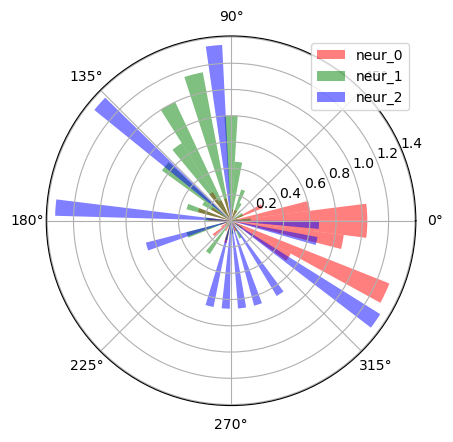

In [40]:
angles_radians = np.linspace(0, 2 * np.pi, 32, endpoint=True)  # angles array in radians
sig_angles_0 = angles_from_counts(neurons['neur_0'])
sig_angles_1 = angles_from_counts(neurons['neur_1'])
sig_angles_2 = angles_from_counts(neurons['neur_2'])

# Rose plot histogram proportional to activity
ax = plt.subplot(111, polar=True)
ax.hist(sig_angles_0, bins=50, color='r', alpha=0.5, density=True)
ax.hist(sig_angles_1, bins=50, color='g', alpha=0.5, density=True)
ax.hist(sig_angles_2, bins=50, color='b', alpha=0.5, density=True)
ax.legend(['neur_0', 'neur_1', 'neur_2'])
plt.show()

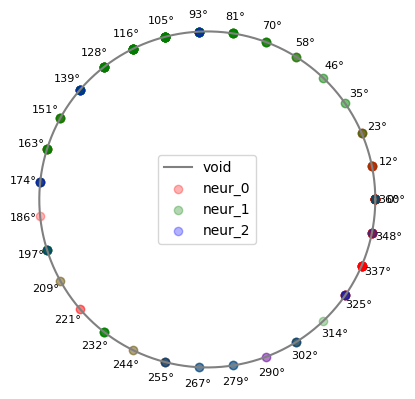

In [43]:
# ALTERNATIVELY, one could represent the data on a scatter plot by projecting
# the angles onto rectangular co-ordinates
# Try that here! (hint: draw sketches or check the notes if unsure :))
ax = plt.subplot(111, aspect='equal')
ax.plot(np.cos(np.linspace(0, 2*np.pi, 500)),
    np.sin(np.linspace(0, 2*np.pi, 500)),
    c='gray')

# Add labels for angles
for angle in angles_radians:
    ax.text(1.1 * np.cos(angle), 1.1 * np.sin(angle), f'{np.degrees(angle):.0f}°',
            horizontalalignment='center', verticalalignment='center', fontsize=8, color='black')

ax.axis('off')
ax.scatter(np.cos(sig_angles_0), np.sin(sig_angles_0), c='r', alpha=0.3)
ax.scatter(np.cos(sig_angles_1), np.sin(sig_angles_1), c='g', alpha=0.3)
ax.scatter(np.cos(sig_angles_2), np.sin(sig_angles_2), c='b', alpha=0.3)
ax.legend(['void', 'neur_0', 'neur_1', 'neur_2'])
plt.show()

What do you notice about the various plots? Could you say anything about which neuron is or is not selective to a given orientation from these?

*From the polar histogram, the neurons neur_0 and neur_1 appear to have responses that are more confined to a range of angles than neur_2.*

## Circular means and mean resultant vector

### Task 2: Calculate the circular mean in different ways.

1. Code up the linear mean as we are used to.
2. Code up the extrinsic definition of the circular mean.
3. The intrinsic definition (i.e. arc distance L2 minimisation with complex number form for angles, as we covered in the lecture) is built-in to ``scipy.stats.circmean``. You can use that function directly (imported as ``int_mean``).

Now compare these different types of mean on the three neurons. For which neuron do these definitions agree most? Why -- what is special about the distribution of angles that that neuron likes?

Next, use ``scipy.stats.circvar``, imported as ``ext_var`` which calculate $1-R$, one minus the mean resultant vector, to calculate $R$. What does this quantity look like for each set of angles? What does this tell us about the neural data in each case?

**Bonus**: Show that the extrinsic circular mean $\bar{\alpha}$ minimises the sum of cosine errors, that is:
\begin{equation*}
\bar{\alpha} = \arg \min_\alpha  \sum_{i=1}^N \big(1-\cos(\theta_i-\alpha)\big)
\end{equation*}

_Hint: You may want to wait until after we discuss the von Mises maximum likelihood estimation to think about this extension problem!_

In [44]:
def lin_mean(angles):
  return np.mean(angles)

def ext_mean(angles):
  return np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles)))

def int_mean(angles):
  return ss.circmean(angles)

def ext_var(angles):
  return 1-ss.circvar(angles)

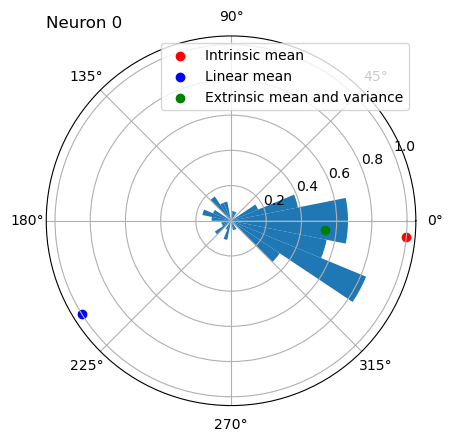

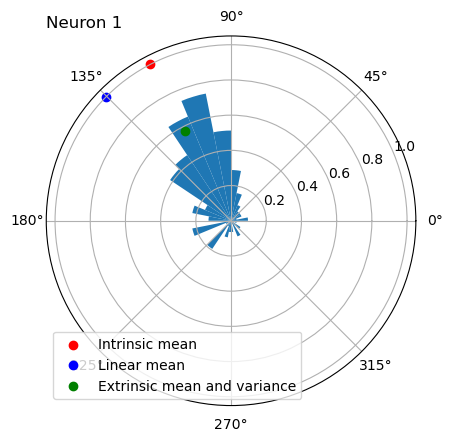

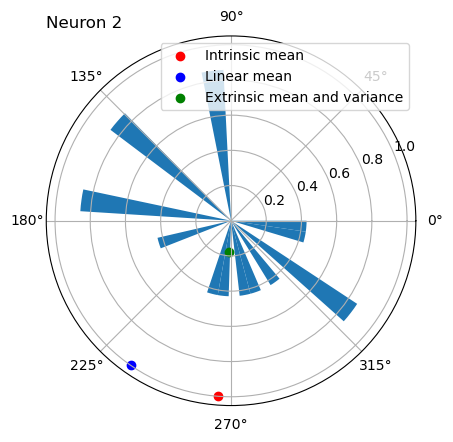

In [45]:
## RUN ME to test your functions on the different neurons

def plot_var_and_mean(angles,title):
  ax = plt.subplot(111, polar=True)
  ax.hist(angles, bins=32, density=True)
  ax.scatter(int_mean(angles),1,marker='o',c='r',label='Intrinsic mean')
  ax.scatter(lin_mean(angles),1,marker='o',c='b',label='Linear mean')
  ax.scatter(ext_mean(angles),ext_var(angles),marker='o',c='g',label='Extrinsic mean and variance')
  ax.legend()
  ax.set_title(title,loc='left')
  plt.show()

plot_var_and_mean(sig_angles_0,title='Neuron 0')
plot_var_and_mean(sig_angles_1,title='Neuron 1')
plot_var_and_mean(sig_angles_2,title='Neuron 2')

*Linear mean does not reflect the central clustering of the angles to which the neurons respond. INtrinsic and extrisic means do. Extrinsic mean beaing closer to the centre of the polar coordinates, e.g. neur_2 vs neur_0, respesents more dispersion of the data as seen by the hsitogram bars too.*

## Maximum likelihood estimation procedure to fit tuning curves using the von Mises distribution

Let's discuss the general approach to fitting a maximum likelihood estimate and try to apply it to fitting tuning curves to the angular data.

The goal of maximum likelihood estimation is to find the values (caled a "point estimate") of the model parameters that maximize the likelihood function. That is:

\begin{equation*}
\hat{\theta}_{MLE} := {\arg \max}_{\theta} p(\mathcal{D} \mid \theta),
\end{equation*}

where the parameters are $\theta$, $\mathcal{D}$ stands for data, and $p$ is the likelihood.

Let's apply this framework to fitting the optimal parameters for a von Mises distribution to the distribution of angles of a neuron. As a reminder, the von Mises PDF is:

\begin{equation}
f(\theta | \mu, \kappa) = \frac{e^{\kappa \cos(\theta - \mu)}}{2\pi I_0(\kappa)}
\end{equation}

where $\theta$ is the observed angle, $\mu$ is the mean direction, $\kappa$ is the concentration parameter, and $I_0$ is the modified Bessel function of the first kind (order 0).

Given $n$ independent data points (angles) $\{\theta_1,\theta_2,...,\theta_n\}$, we want to compute the MLE parameter that tells us the best $\mu,\kappa$ parameter. The likelihood function is just the product of independent von Mises PDFs:

\begin{equation}
P(\mathcal{D} \vert \mu, \kappa) = \prod_{i=1}^{n} \frac{e^{\kappa \cos(\theta_i - \mu)}}{2\pi I_0(\kappa)}
\end{equation}

The MLE does exactly what it says: chooses *parameters that maximise* this quantity. How do we go about that? Remember in calculus that maxima and minima of functions have gradients with 0 slope. To _optimise_ a function for a given parameter, we simply take the partial derivative with respect to the parameter, set it to 0, then solve for the parameter.

### Task 3: Analytical fit of the MLE for a von Mises tuning curve

Use MLE to find the mean paramater of a von Mises to fit some angular data. To help you get started, follow these steps:

1. Write down the **negative log likelihood** ($\text{NLL}(\theta)$) for $P(\mathcal{D} \vert \mu, \kappa)$. This changes the maximisation problem into a minimisation problem (negative) but doesn't change the outcome of which value is optimal (logarithm is a monotonic function). Why do it? It'll make the maths a lot easier. Try to simplify as far as you can go!

2. Identify the terms in the NLL dependent on $\mu$. These we will minimise over.

3. You should find some terms in the expression in 2 that look like a $cos(\theta_i - \mu)$. It'll help to simplify this using the trigonometric identity: $\cos(\theta_i - \mu) = \cos \theta_i \cos \mu + \sin \theta_i \sin \mu.$

4. Now take the partial derivative $\frac{\partial}{\partial\mu}$ of this expression with respect to $\mu$.

5. Set the partial equal to 0 and solve for $\mu$.

6. What do you notice? Does it look like something you've encountered before in this tutorial?



You can do the same procedure to find the analytical form for the concentration $\kappa$, but it turns out to not be as easy to solve analytically (people often use approximations), so we'll skip that!

Instead, notice that since this is just an optimisation problem, we could also have given it to a solver. We'll do that, next, and compare the fits for the different neurons.

### Task 4: Use the MLE derivation to fit the parameters for von Mises tuning curves for the neurons.

This task is a little less structured, but you should know enough to solve it.

We'll use a numerical solver to solve the optimisation problem: you can either build your own, use an in-built minimiser, or make use of ``scipy.stats`` in-built functions. In particular, you could check the documentation for and then use ``scipy.stats.vonmises.fit`` to fit the mean and concentration parameter for each neuron in one line of code!

Plot these von Mises fits and compare them to the means we calculated and the true data distribution (you can copy the polar histograms above, and then overlay the plot for the fit von Mises!).

**Bonus!** What test could we use to check whether our fits are any good? Is there a circular variant of the K-S test? Why can't you use the K-S test (or similar) directly?

(1.2706063994090369, np.float64(-0.09421587498174766), 1)


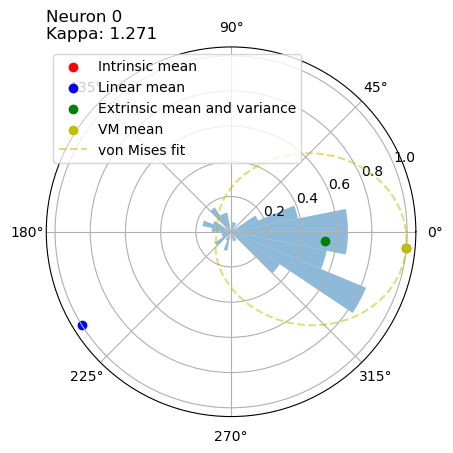

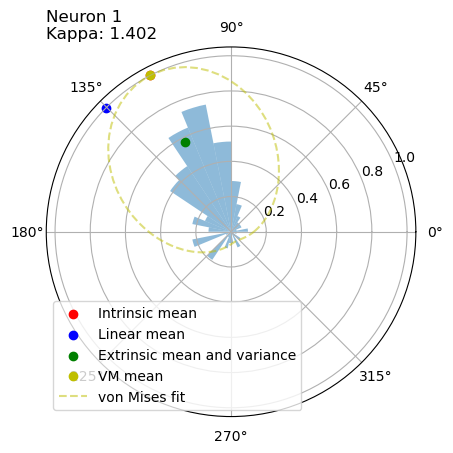

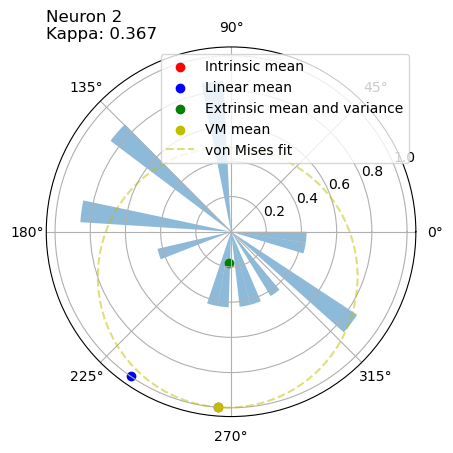

In [63]:
### YOUR CODE HERE
def plot_var_and_mean_VM(angles, title):
  kappa, mu, _ = ss.vonmises.fit(angles, fscale=1)
  ax = plt.subplot(111, polar=True)
  ax.hist(angles, bins=32, density=True, alpha=0.5)
  ax.scatter(int_mean(angles), 1, marker='o', c='r', label='Intrinsic mean')
  ax.scatter(lin_mean(angles), 1, marker='o', c='b', label='Linear mean')
  ax.scatter(ext_mean(angles), ext_var(angles), marker='o', c='g', label='Extrinsic mean and variance')
  ax.scatter(mu, 1, marker='o', c='y', label='VM mean')
  
  # Plot von Mises distribution
  theta = np.linspace(0, 2 * np.pi, 100)
  vm_pdf = ss.vonmises.pdf(theta, kappa, loc=mu)
  ax.plot(theta, vm_pdf / vm_pdf.max(), 'y--', alpha=0.5, label='von Mises fit')
  
  ax.legend()
  ax.set_title(f'{title}\nKappa: {kappa:.3f}', loc='left')
  plt.show()

plot_var_and_mean_VM(sig_angles_0, title='Neuron 0')
plot_var_and_mean_VM(sig_angles_1, title='Neuron 1')
plot_var_and_mean_VM(sig_angles_2, title='Neuron 2')


In [72]:
for angles in [sig_angles_0, sig_angles_1, sig_angles_2]:
  stat, p_value = ss.rayleigh.fit(angles)
  print(f"Rayleigh Test: Statistic = {stat}, p-value = {p_value}")

Rayleigh Test: Statistic = -1.195203103838573, p-value = 3.879021786138938
Rayleigh Test: Statistic = -0.11742090244560763, p-value = 1.9542669873629257
Rayleigh Test: Statistic = 1.0289361967001693, p-value = 2.4292242104209616


c:\Anaconda\envs\statsNeuro\Lib\site-packages\scipy\stats\_continuous_distns.py:8831: RuntimeWarning: overflow encountered in divide
  s3 = (1/xm).sum()


*For all neurons, the Rayleight test failed to reject the null hypothesis stating that the data is uniformly distributed. Thus, there's not enough evidence to conclude that the activity of selected neurons has a preferred angular direction.*

## Tests for uniformity

### Task 5 [Optional]: Use a frequentist test for uniformity.

Find a library that offers a test for uniformity (e.g. ``astropy``). Are any neurons' firing to orientation approximately uniform, i.e. non-selective? If you have time, compare different tests for uniformity on each data set.

In [82]:
### OPTIONAL :)